In [1]:
# This class tests whether the tensorflow and autograd versions give identical outputs for a simple least squared loss function

In [1]:
from autograd import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sopt.optimizers.autograd.lma import LMA as LMAag
from sopt.optimizers.tensorflow import LMA as LMAtf

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
z_true = np.random.randn(3,10).astype('float32')

random_mat = np.random.randn(3,3)
random_symmetric_mat = random_mat + random_mat.T
evals, evecs = np.linalg.eig(random_symmetric_mat)
affine_transform = evecs

y_true = affine_transform @ z_true
y_true_flat = y_true.flatten()

In [4]:
def y_pred(z_flat):
    z_arr = np.reshape(z_flat, (3, -1))
    return (affine_transform @ z_arr).flatten()

def loss_fn(y):
    return 0.5 * np.sum((y - y_true_flat)**2)

In [5]:
z_guess = np.random.randn(30).astype('float32')

In [6]:
# Testing the autograd implementations

In [7]:
ag_lma1 = LMAag(z_guess, y_pred, loss_fn, squared_loss=True, damping_factor=1., cg_tol=1e-5)
ag_lma2 = LMAag(z_guess, y_pred, loss_fn, squared_loss=False, damping_factor=1., cg_tol=1e-5)

In [8]:
ag_losses1 = []
ag_losses2 = []
for i in range(10):
    out1 = ag_lma1.minimize()
    out2 = ag_lma2.minimize()
    print(i, loss_fn(y_pred(out1)), loss_fn(y_pred(out2)))
    ag_losses1.append(loss_fn(y_pred(out1)))
    ag_losses2.append(loss_fn(y_pred(out2)))

0 8.698775145351032 8.698775145351032
1 1.3918040232561655 1.3918040232561655
2 0.13176842823726992 0.13176842823726992
3 0.006884228087498141 0.006884228087498141
4 0.00018730602512483308 0.00018730602512483308
5 2.536216459211213e-06 2.536216459211213e-06
6 1.6519613797415876e-08 1.6519613797415876e-08
Stopping iteration. Very low loss value: 1.6519613797415876e-08
Stopping iteration. Very low loss value: 1.6519613797415876e-08
7 1.6519613797415876e-08 1.6519613797415876e-08
Stopping iteration. Very low loss value: 1.6519613797415876e-08
Stopping iteration. Very low loss value: 1.6519613797415876e-08
8 1.6519613797415876e-08 1.6519613797415876e-08
Stopping iteration. Very low loss value: 1.6519613797415876e-08
Stopping iteration. Very low loss value: 1.6519613797415876e-08
9 1.6519613797415876e-08 1.6519613797415876e-08


In [9]:
# Tensorflow test

In [10]:
tf.reset_default_graph()
var1 = tf.get_variable('var1', dtype=tf.float32, initializer=z_guess)
var2 = tf.get_variable('var2', dtype=tf.float32, initializer=z_guess)

tf_y_true = tf.convert_to_tensor(y_true_flat, dtype='float32', name='y_true')
tf_affine_transform = tf.convert_to_tensor(affine_transform, dtype='float32', name='affine_transform')

def tf_y_pred(z):
    return tf.reshape(tf_affine_transform @ tf.reshape(z, [3, -1]), [-1])
def tf_loss(y_pred):
    return 0.5 * tf.reduce_sum((tf_y_true - y_pred)**2)
def tf_hessian(y_pred):
    return 1.0

preds1 = tf_y_pred(var1)
preds2 = tf_y_pred(var2)
loss_tensor1 = tf_loss(preds1)
loss_tensor2 = tf_loss(preds2)

tf_lma1 = LMAtf(var1, tf_y_pred, tf_loss, name='opt1', min_cg_tol=1e-5, mu=1.0, assert_tolerances=False)
tf_lma2 = LMAtf(var2, tf_y_pred, tf_loss, name='opt2', diag_hessian_fn=tf_hessian, mu=1.0, min_cg_tol=1e-5, assert_tolerances=False)

tf_lma1_min = tf_lma1.minimize()
tf_lma2_min = tf_lma2.minimize()
session = tf.Session()
session.run(tf.global_variables_initializer())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [11]:
tf_losses1 = []
tf_losses2 = []
for i in range(10):
    session.run([tf_lma1_min, tf_lma2_min])
    lossval1, lossval2 = session.run([loss_tensor1, loss_tensor2])
    tf_losses1.append(lossval1)
    tf_losses2.append(lossval2)
    

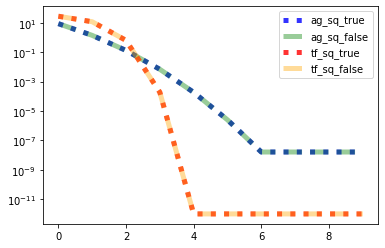

In [12]:
plt.plot(ag_losses1, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='ag_sq_true')
plt.plot(ag_losses2, color='green', ls='--', linewidth=5.0, alpha=0.4, label='ag_sq_false')
plt.plot(np.array(tf_losses1), color='red', ls=':', linewidth=5.0, alpha=0.8, label='tf_sq_true')
plt.plot(np.array(tf_losses2), color='orange', ls='--', linewidth=5.0, alpha=0.4, label='tf_sq_false')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [13]:
session.run(var1)

array([ 0.94212073, -0.60890114,  1.8922179 ,  1.800665  , -0.6595634 ,
        1.1513674 ,  2.5602334 ,  0.62434554, -0.5158502 ,  1.3642477 ,
       -0.38392103, -0.03784891,  1.975527  , -1.9850752 , -0.7468484 ,
       -1.0584342 ,  0.4697912 ,  1.3332471 , -0.5838368 , -0.12007757,
        2.0366907 , -1.8848974 ,  0.9140864 , -0.44323444,  1.481767  ,
       -0.4299333 , -0.6108971 ,  0.5125114 ,  0.03852862,  0.6835428 ],
      dtype=float32)

In [14]:
z_true

array([[ 0.942121  , -0.60890096,  1.8922185 ,  1.800665  , -0.65956366,
         1.1513677 ,  2.5602338 ,  0.6243456 , -0.51585   ,  1.364248  ],
       [-0.38392103, -0.03784892,  1.9755274 , -1.9850758 , -0.74684846,
        -1.0584344 ,  0.46979144,  1.3332477 , -0.5838371 , -0.12007753],
       [ 2.036691  , -1.8848977 ,  0.91408634, -0.44323456,  1.481767  ,
        -0.4299331 , -0.6108971 ,  0.5125113 ,  0.03852856,  0.68354285]],
      dtype=float32)